In [1]:
import torch
from torchvision import datasets, transforms
# transform -> preprocess before fed to the network
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,),(.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download = True, transform = transform)
training_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 100, shuffle=True)


def image_convert(tensor):
    # 원래 이미지로 돌려놓기 위한 함수
    
    image = tensor.clone().detach().numpy() # create new copy + detach
    # [color channel, width, height] 값으로 구분됨. 엠니스트의 경우 1 * 28 * 28
    
    image = image.transpose(1,2,0) # 28*28*1로 변경
    image = image * np.array((.5,.5,.5)) + np.array((.5,.5,.5)) #정규화한 작업을 풀어주는 거 같은데...

    # 학습을 위해 0~1 값을 -1~1로 변경했으므로, 이걸 되돌려 준다
    image = image.clip(0,1) # min을 0, max를 1로 변경해주는 것
    return image

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        # Conv2d(input_channel 개수, output_channel 개수(feature map 개수), kernal size(3 by 3, 5 by 5), stride)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2,2) # 2 by 2 kernal을 사용하겠단 뜻.
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2,2) # 2 by 2 kernal을 사용하겠단 뜻.
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [4]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = .0001)

In [5]:
epochs = 12

losses = []
correct_history = []
for e in range(epochs):
    running_loss = 0
    running_correct = 0
    for images, labels in training_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        _, pred = torch.max(outputs,1) # 튜플이 나올 때 첫번째 값은 image 연산결과고, 두 번째가 label값이 될 것.
        # max(output,1)에서 1은 dim으로, 1이기 때문에 각 row별 최대값을 구함.

#  tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
#         [ 1.1949, -1.1127, -2.2379, -0.6702],
#         [ 1.5717, -0.9207,  0.1297, -1.8768],
#         [-0.6172,  1.0036, -0.6060, -0.2432]])
# torch.max(a, 1)
# (tensor([ 0.8475,  1.1949,  1.5717,  1.0036]), tensor([ 3,  0,  0,  1]))

        running_correct +=torch.sum(pred == labels.data)
        running_loss += loss.item()
        
    else:
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_correct.float() / len(training_loader)
        losses.append(epoch_loss)
        correct_history.append(epoch_acc)
        print('training loss: {:4f}, Accuracy: {:4f}'.format(epoch_loss, epoch_acc))
    

NameError: name 'device' is not defined

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

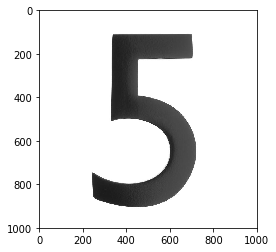

In [8]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [10]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(image_convert(img))

OSError: not supported for this image mode

In [11]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

RuntimeError: size mismatch, m1: [1 x 3050450], m2: [800 x 500] at /Users/soumith/mc3build/conda-bld/pytorch_1549593514549/work/aten/src/TH/generic/THTensorMath.cpp:940